<a href="https://colab.research.google.com/github/angadbajwa23/Brain-Image-Segmentation/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
%cd gdrive/My Drive

/content/gdrive/My Drive


In [2]:
import matplotlib.pyplot as plt
from numpy import load
import numpy as np
import h5py
import tensorflow as tf
import numpy as np
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

Using TensorFlow backend.


In [3]:
#K.set_image_dim_orderin("th")
K.set_image_data_format('channels_last')

img_size = 240      #original img size is 240*240
smooth = 0.005 
num_of_aug = 2
num_epoch = 30
pul_seq = 'Flair'
sharp = False       # sharpen filter
LR = 1e-4

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis+NET, 2 = tumor core,3= original, 4 = ET, 5 = complete tumor
'''
0: other
1: necrosis + NET
2: edema
4: enhancing tumor
5: full tumor
'''
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """


tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [4]:
# load dict of arrays
dict_data = load('flair.npz')
# extract the first array
flair = dict_data['arr_0']
flair=flair[:10,:]
# print the array
flair.shape

(10, 240, 240, 155, 1)

In [5]:
dict_data = load('label_full.npz')
# extract the first array
label_full= dict_data['arr_0']
# print the array
label_full=label_full[:10,:]
label_full.shape

(10, 240, 240, 155, 1)

In [0]:
flair=np.resize(flair,(10,240,240,128,1))

In [0]:
label_full=np.resize(label_full,(10,240,240,128,1))

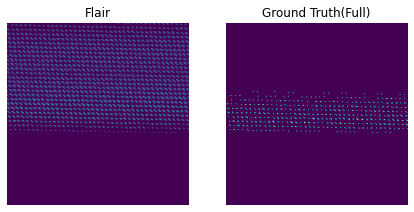

In [11]:
plt.figure(figsize=(15,10))

plt.subplot(241)
plt.title('Flair')
plt.axis('off')
plt.imshow(flair[10, :, :, 100,0])
plt.subplot(242)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(label_full[10, :, :, 100,0])

In [0]:
with h5py.File('Train.hdf5', 'w') as hf:
    hf.create_dataset("flair", data=flair)
    hf.create_dataset("gt", data=label_full)


In [0]:
with h5py.File('Name.h5', 'r') as hf:
    flair = hf['flair'][:]
    gt=hf['gt'][:]

In [0]:
with h5py.File('Train.hdf5', 'r') as hf:
    train_flair = hf['flair'][:168,:]
    train_gt=hf['gt'][:168,:]

In [0]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model

In [0]:

img_depth=128
img_rows=240
img_cols=240

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

def get_unet():
    inputs = Input((img_rows, img_cols,img_depth,1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [10]:
model2=get_unet()
model2.summary

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 128 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 240, 240, 128 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 240, 240, 128 27680       conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 120, 120, 64, 0           conv3d_2[0][0]                   
____________________________________________________________________________________________

<bound method Network.summary of <keras.engine.training.Model object at 0x7f5df70224a8>>

In [0]:
model2.fit(flair,label_full, batch_size=1, epochs=1, verbose=2, shuffle=True)

Epoch 1/1


In [0]:
flair.shape

(168, 240, 240, 128, 1)

In [0]:
label_full.shape